# Problems

[Try this yourself](https://colab.research.google.com/github/DTUWindEnergy/TopFarm2/blob/master/docs/notebooks/problems.ipynb) (requires google account)


In TOPFARM the problem is the collection/container of components and drivers. Optimizing a problem is executing a workflow - finding the best feasible solution under a series of constraints using a specific driver and initial conditions. To the problem is also attached a plotting routine so one can follow the optimization path as well as a recorder so that intermediate variable values are accessible after the optimization is finished.

The `TopfarmProblem` inherits its fundamental nature from the OpenMDAO problem, and is being adapted so it can connect the given workflow with the driver. For example, if the user specifies a boundary constraint and this is not supported by the driver, the Problem is equipped with a penalty component that will deter the driver giving unfeasible solutions. Or if your workflow does not have gradients for all components and a gradient based driver is specified, finite differencing is applied to obtain the gradients.

The `TopFarmProblem` is defined as a class, and it is comprised of the following elements:

    def __init__(self, design_vars, cost_comp=None, driver=EasyScipyOptimizeDriver(),
                 constraints=[], plot_comp=NoPlot(), record_id=None,
                 expected_cost=1, ext_vars={}, post_constraints=[], approx_totals=False,
                 recorder=None, additional_recorders=None,
                 n_wt=0, grid_layout_comp=None):

It takes the design variables, cost model component, driver and constraints as the most important parameters. In addition, it has a feature to visualize the optimization with a plotting component, and the use of additional constraints (for example, fatigue loading) can be specified with the **post_constraints** option. The latest development also allows the user to have a regular wind farm layout instead of irregular and individual position of turbines during a layout optimization. To do this, use the **grid_layout_comp**.

Before working on the notebook exercises, make sure that you import or install TOPFARM on your newly created environment.

In [ ]:
# Install TopFarm if needed
import importlib
if not importlib.util.find_spec("topfarm"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git

**Import supporting libraries in Python**

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

**Next we import and initialize several functions and classes from TOPFARM to set up the problem including:**

- **TopFarmProblem**. Overall topfarm problem class to which the objectives, design variables, and constraints are added
- **EasyScipyOptimizeDriver**. A subclass of ScipyOptimizeDriver which is configured for the given workflow
- **get_iea37_initial, get_iea37_constraints, get_iea37_cost**. Functions to get the initial layout, the constraints and the cost function for the IEA task 37 benchmark example
- **NoPlot, XYPlotComp**. Plotting components to visualize the results

In [2]:
from topfarm import TopFarmProblem
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm.examples.iea37 import get_iea37_initial, get_iea37_constraints, get_iea37_cost
from topfarm.plotting import NoPlot, XYPlotComp

## Turbine location optimization - Example 1

This example optimizes the locations of the 9-turbine benchmark wind farm from IEA Task 37 using the provided initial locations and the `EasyScipyOptimizeDriver`. Details on the benchmark can be found in the following reference:  

- Baker et al. (2019) "Best Practices for Wake Model and Optimization Algorithm Selection in Wind Farm Layout Optimization". AIAA 2019.

First we set up the number of turbines and initial positions.

In [3]:
n_wt = 9          #valid number of turbines are: 9, 16, 36, 64
x, y = get_iea37_initial(n_wt).T

Now we import from PyWake the wake model, wind turbine and site objects to define our objective function, which is represented by the AEP (see https://topfarm.pages.windenergy.dtu.dk/PyWake/index.html for more information).

In [4]:
from py_wake.deficit_models.gaussian import IEA37SimpleBastankhahGaussian   #wake model
from py_wake.examples.data.iea37 import IEA37_WindTurbines, IEA37Site       #wind turbines and site used

site = IEA37Site(n_wt)
wind_turbines = IEA37_WindTurbines()

wake_model = IEA37SimpleBastankhahGaussian(site, wind_turbines)
wd = np.linspace(0., 360., 16, endpoint=False)                              #number of wind directions to study

#objective function
def aep_func(x,y,wd=wd):
    sim_res = wake_model(x,y, wd=wd)
    aep = sim_res.aep().sum()
    return aep

Then we set up the `CostModelComponent` that will be used for the optimization as well as the constraints of the problem.

The cost model component is defined as:

    def __init__(self, input_keys, n_wt, cost_function, cost_gradient_function=None,
                 output_keys=["Cost"], output_unit="", additional_input=[], additional_output=[], max_eval=None,
                 objective=True, maximize=False, output_vals=[0.0], input_units=[], step={}, use_penalty=True, **kwargs):

where it takes the design variables as input keys and the objective function as the cost function. In addition, the gradient function can be specified when necessary. By default, the objective is set to True and the maximize to False, which treats the optimization as a minimization problem.

In [5]:
from topfarm.cost_models.cost_model_wrappers import CostModelComponent

constraint = get_iea37_constraints(n_wt)

aep_comp = CostModelComponent(input_keys=['x','y'],
                              n_wt=n_wt,
                              cost_function=aep_func,
                              output_keys=[('AEP', 0)],
                              output_unit="GWh",
                              objective=True,
                              maximize=True
                             )

Lastly, we set up the `TopFarmProblem` with the previously defined `CostModelComponents` and design variables x and y.

In [6]:
problem = TopFarmProblem(design_vars={'x': x, 'y': y}, 
                          n_wt=n_wt,
                          cost_comp=aep_comp,
                          constraints=constraint,
                          driver=EasyScipyOptimizeDriver(disp=False),
                          plot_comp=XYPlotComp()
                        )

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


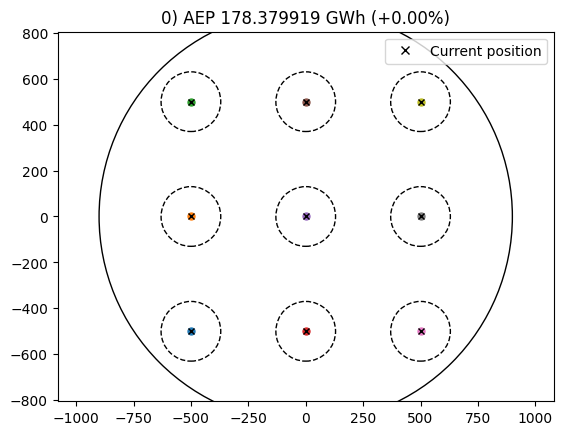

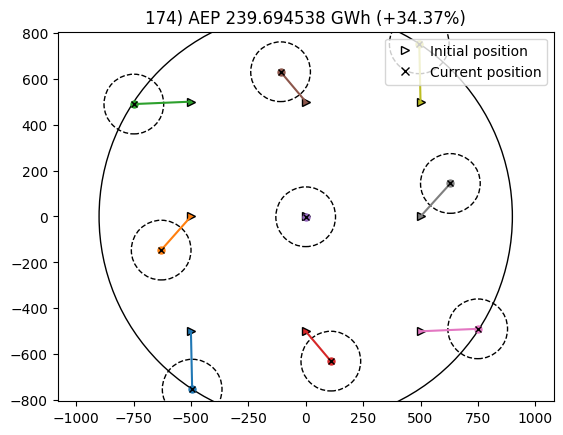

In [7]:
_, state,_ = problem.optimize()

In [8]:
state

{'x': array([-4.94539855e+02, -6.29537010e+02, -7.48568271e+02,  1.09399603e+02,
        -1.69332898e-01, -1.09517968e+02,  7.49038783e+02,  6.30016923e+02,
         4.94531938e+02]),
 'y': array([-751.95101669, -146.37234927,  489.61636907, -629.91441837,
          -1.25908733,  630.3559948 , -489.34014506,  143.80226704,
         751.95622391])}

## Turbine location optimization - Example 2

Alternatively, we can use the `PyWakeAEPCostModelComponent` as the cost model for the optimization.

In [9]:
from py_wake.deficit_models.gaussian import IEA37SimpleBastankhahGaussian   #wake model
from py_wake.examples.data.iea37 import IEA37_WindTurbines, IEA37Site       #wind turbines and site used
from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponent #cost model

#creating a function to simulate the flow conditions of the IEA37 Site, specifying the desired number of turbines and wind directions
def get_iea37_cost(n_wt=9, n_wd=16):
    
    """Cost component that wraps the IEA 37 AEP calculator"""
    wd = np.linspace(0., 360., n_wd, endpoint=False)
    site = IEA37Site(n_wt)
    wind_turbines = IEA37_WindTurbines()
    wake_model = IEA37SimpleBastankhahGaussian(site, wind_turbines)    
    
    return PyWakeAEPCostModelComponent(wake_model, n_wt, wd=wd)

Now we create a function that specifies the optimization problem, with the desired design variables, constraints, and driver.

In [10]:
def optimize_iea37_locs(n_wt, n_wd, driver, state=None):
    """
    Parameters
    ----------
    - n_wt: int
        Number of wind turbines

    - n_wd: int
        Number of wind directions to consider for the AEP
        
    - driver: TopfarmDriver instance
        The optimization algorithm to use
        
    - state: dict(x=[], y=[]) [default=None]
        State to start from the optimization
    
    Returns
    -------
    - state: The state after the optimization

    """
    
    initial = get_iea37_initial(n_wt)
    design_vars = dict(zip('xy', (initial[:, :2]).T))
    
    tf = TopFarmProblem(
            design_vars,
            get_iea37_cost(n_wt, n_wd=n_wd),
            constraints=get_iea37_constraints(n_wt),
            driver=driver,
            plot_comp=XYPlotComp())
    
    if not state:
        _, state = tf.evaluate()
        
    _, state, _ = tf.optimize(state)
    return state, 

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


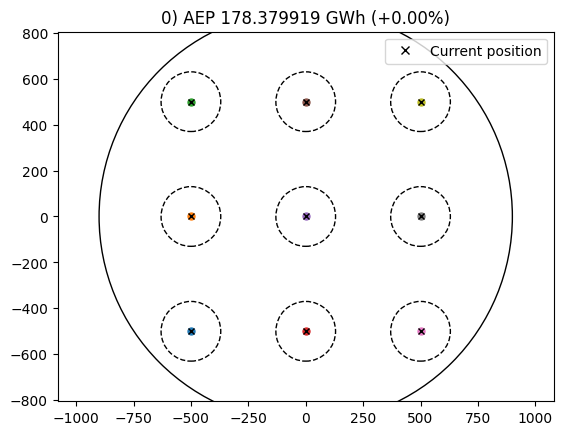

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


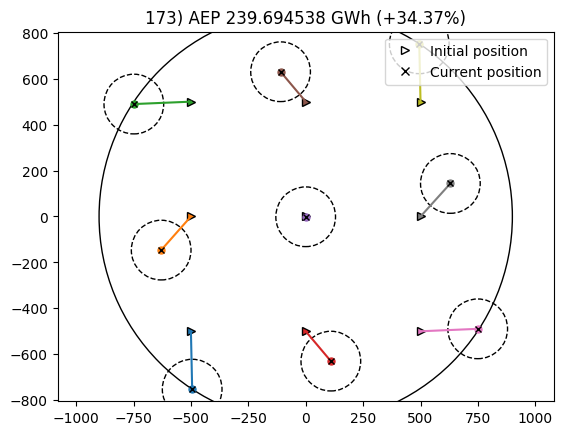

In [11]:
state = optimize_iea37_locs(9, 16, EasyScipyOptimizeDriver(disp=False))

We can see that the optimized AEP corresponds to 239.69 GWh and an improvement of 34.37% is found. However, these value is lower than the one reported in Baker et al. (2019) of 257.790 GWh.

Moreover, the layout does not match the figures given in Appendix A in the same reference. This is due to the fact that the SLSQP optimizer was attracted to a local minimum. To find the global optimum, more advanced optimization procedures should be used. This benchmark is discussed in more detail in the validation report linked in TOPFARM's documentation.

To obtain the final turbine positions that correspond to the optimum AEP found, we need to call the state object.

In [12]:
state

({'x': array([-4.94541038e+02, -6.29538241e+02, -7.48569543e+02,  1.09398064e+02,
         -1.70674720e-01, -1.09519177e+02,  7.49037349e+02,  6.30015331e+02,
          4.94530552e+02]),
  'y': array([-751.95023868, -146.37144379,  489.61742481, -629.91364565,
           -1.25798289,  630.35702146, -489.33929999,  143.8036631 ,
          751.95713489])},)